# Investigating the structure and components of the project files

In [5]:
import os

In [6]:
!pip install seaborn cryptography

In [7]:
%cd ~/Project-Build-an-ML-Pipeline-Starter

/home/dan/Project-Build-an-ML-Pipeline-Starter


In [8]:
%ls

 artifacts/
'Build an ML Pipeline for Short-Term Rental Prices in NYC.ipynb'
 CODEOWNERS
 components/
 conda.yml
 config.yaml
 environment.yml
 images/
 LICENSE.txt
 main.py
 MLproject
 mlruns/
 outputs/
 prime_finder_gpu.py
 prime_finder_trillion.py
 README.md
 src/
 Untitled.ipynb
 UPGRADE_NOTES.md
 wandb/


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# Initialize wandb
run = wandb.init(project="nyc_airbnb", job_type="eda")

# Download the artifact from download step
artifact = run.use_artifact('dthomson3-western-governors-university/nyc_airbnb/sample.csv:latest')
artifact_path = artifact.file()

# Load data
df = pd.read_csv(artifact_path)
df.head()

wandb: Currently logged in as: dthomson3 (dthomson3-western-governors-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9138664,Private Lg Room 15 min to Manhattan,47594947,Iris,Queens,Sunnyside,40.74271,-73.92493,Private room,74,2,6,2019-05-26,0.13,1,5
1,31444015,TIME SQUARE CHARMING ONE BED IN HELL'S KITCHEN...,8523790,Johlex,Manhattan,Hell's Kitchen,40.76682,-73.98878,Entire home/apt,170,3,0,NaN,NaN,1,188
2,8741020,Voted #1 Location Quintessential 1BR W Village...,45854238,John,Manhattan,West Village,40.73631,-74.00611,Entire home/apt,245,3,51,2018-09-19,1.12,1,0
3,34602077,Spacious 1 bedroom apartment 15min from Manhattan,261055465,Regan,Queens,Astoria,40.76424,-73.92351,Entire home/apt,125,3,1,2019-05-24,0.65,1,13
4,23203149,Big beautiful bedroom in huge Bushwick apartment,143460,Megan,Brooklyn,Bushwick,40.69839,-73.92044,Private room,65,2,8,2019-06-23,0.52,2,8


In [10]:
df.shape

(20000, 16)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20000 non-null  int64  
 1   name                            19993 non-null  object 
 2   host_id                         20000 non-null  int64  
 3   host_name                       19992 non-null  object 
 4   neighbourhood_group             20000 non-null  object 
 5   neighbourhood                   20000 non-null  object 
 6   latitude                        20000 non-null  float64
 7   longitude                       20000 non-null  float64
 8   room_type                       20000 non-null  object 
 9   price                           20000 non-null  int64  
 10  minimum_nights                  20000 non-null  int64  
 11  number_of_reviews               20000 non-null  int64  
 12  last_review                     

In [12]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,15877.000000,20000.000000,20000.000000
mean,1.892380e+07,6.746034e+07,40.728455,-73.952125,153.269050,6.992100,23.274100,1.377446,6.955450,112.901200
std,1.101223e+07,7.857936e+07,0.054755,0.046559,243.325609,21.645449,44.927793,1.683006,32.433831,131.762226
min,2.539000e+03,2.571000e+03,40.508730,-74.239140,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.393540e+06,7.853718e+06,40.689420,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.952117e+07,3.111431e+07,40.722730,-73.955640,105.000000,2.000000,5.000000,0.720000,1.000000,44.000000
75%,2.912936e+07,1.068426e+08,40.762990,-73.936380,175.000000,5.000000,23.000000,2.010000,2.000000,229.000000
max,3.648561e+07,2.742733e+08,40.913060,-73.717950,10000.000000,1250.000000,607.000000,27.950000,327.000000,365.000000


## Looking for any missing values

In [13]:
missing = df.isnull().sum()

missing_pct = df.isnull().mean() * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})

print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

                   Missing_Count  Missing_Percentage
reviews_per_month           4123              20.615
last_review                 4123              20.615
host_name                      8               0.040
name                           7               0.035


## Looking for outliers in the price column
* This is likely the column I will use in the machine learning model for prediction.
* after looking at the df.describe(), we can already suspect that with a min of `0` and a max of `10,000` that we might have some outliers.
* These outliers can skew the results, so I want to find them early.

## Observation
* I can clearly see some outliers near the `$0` and `$10,000` listings.
* This explains why the mean of `$153.27` is much higher than the median of `$105.00`

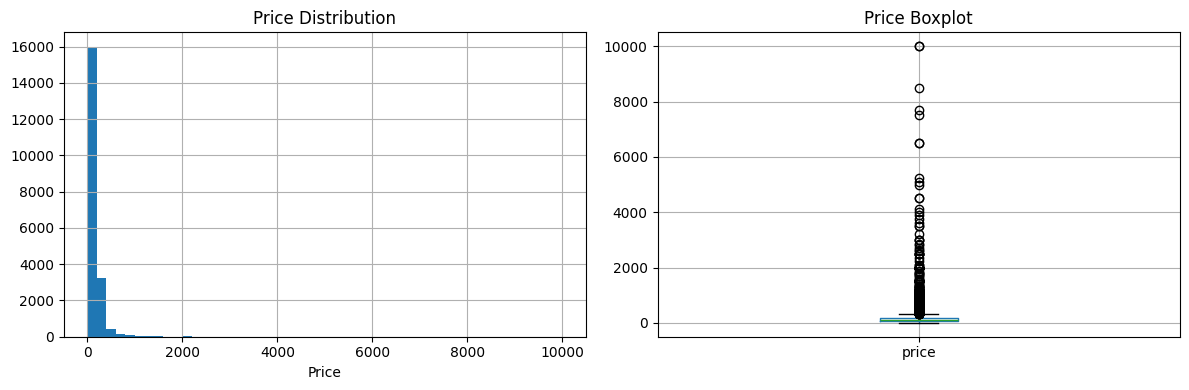

Price stats:
Min: $0
Max: $10000
Mean: $153.27
Median: $105.00


In [14]:
# plotting outliers for better visualization.
# printing the price, min, max, mean, and median right under the plots for clarity.
# adding boxplot for another visual on the distribution of the price column.

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['price'].hist(bins=50)
plt.xlabel('Price')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
df.boxplot(column='price')
plt.title('Price Boxplot')

plt.tight_layout()
plt.show()

print(f"Price stats:")
print(f"Min: ${df['price'].min()}")
print(f"Max: ${df['price'].max()}")
print(f"Mean: ${df['price'].mean():.2f}")
print(f"Median: ${df['price'].median():.2f}")

## Investigating data types and looking for any negative values
* data type mismatches are a common reason why data quality suffers. I want to catch this early.
* It wouldn't make sense for there to be negative values in the price column, so I want to rule that out early as well.

In [15]:
columns_to_check = ['minimum_nights', 'number_of_reviews', 'availability_365', 'price']

print("Summary statistics for key columns:")

print(df[columns_to_check].describe())

# Searching for specific zero/negative checks
print(f"\nNegative prices: {(df['price'] < 0).sum()}")
print(f"Zero prices: {(df['price'] == 0).sum()}")

Summary statistics for key columns:
       minimum_nights  number_of_reviews  availability_365         price
count    20000.000000       20000.000000      20000.000000  20000.000000
mean         6.992100          23.274100        112.901200    153.269050
std         21.645449          44.927793        131.762226    243.325609
min          1.000000           0.000000          0.000000      0.000000
25%          1.000000           1.000000          0.000000     69.000000
50%          2.000000           5.000000         44.000000    105.000000
75%          5.000000          23.000000        229.000000    175.000000
max       1250.000000         607.000000        365.000000  10000.000000

Negative prices: 0
Zero prices: 5


## mininum_nights column needs to be investigated
* a minimum_nights of 1250 is over `three years`.

## Observation
* the outliers appear to be `long-term` leases, not `short-term` leases.
* the goal is to build a model for `short-term` rental prices, then these values will confuse the model.
* catching these early will allow me to filter them out, and build a more accurate model.

Most common minimum_nights (as % of total):
minimum_nights
1     26.240
2     23.980
3     16.545
30     7.700
4      6.640
5      6.040
7      4.275
6      1.535
14     1.085
10     0.915
Name: proportion, dtype: float64

Percentile distribution for minimum_nights:
count    20000.000000
mean         6.992100
std         21.645449
min          1.000000
50%          2.000000
90%         28.000000
95%         30.000000
99%         40.020000
max       1250.000000
Name: minimum_nights, dtype: float64



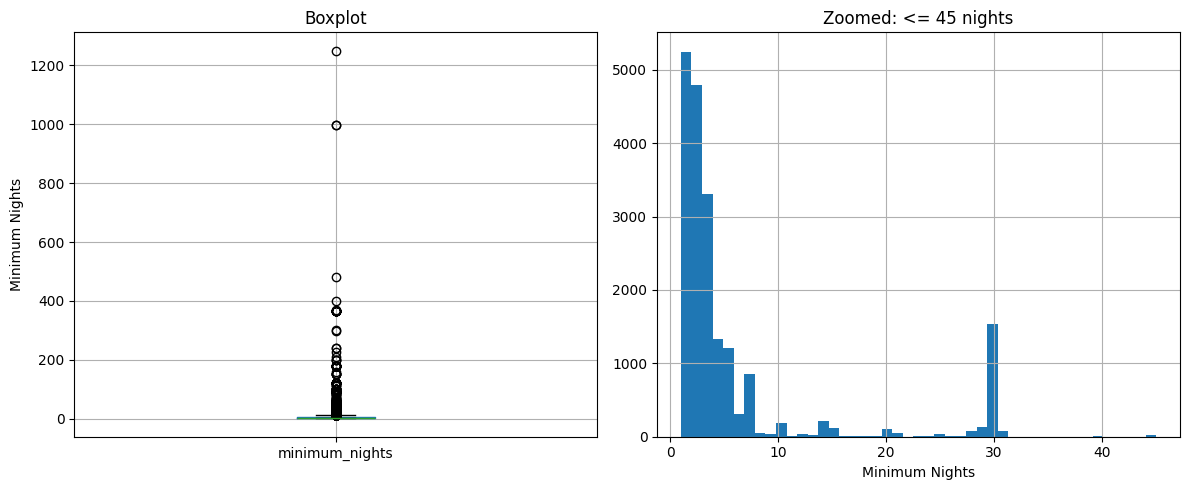


Extreme minimum_nights listings (> 365):
                                      name  price  minimum_nights
733     Historic Designer 2 Bed. Apartment     99             999
3000   Brand New Luxury Apt Lease Takeover    199             480
8981          Shared Studio (females only)    110             999
12174     Prime W. Village location 1 bdrm    180            1250
13116  800sqft apartment with huge terrace    115             370


In [16]:
print("Most common minimum_nights (as % of total):")

print(df['minimum_nights'].value_counts(normalize=True).head(10) * 100)

print("\n" + "="*50)

# This is more direct than manually summing.
# It tells me that "99% of listings have a minimum stay of X nights or less"
print("Percentile distribution for minimum_nights:")
print(df['minimum_nights'].describe(percentiles=[.90, .95, .99]))

print("\n" + "="*50)

# 1x2 plot for the important values
plt.figure(figsize=(12, 5))

# I like the boxplot for a clear visual on outliers
plt.subplot(1, 2, 1)
df.boxplot(column='minimum_nights')
plt.ylabel('Minimum Nights')
plt.title('Boxplot')

# Filtering out the outliers for a clearer view
plt.subplot(1, 2, 2)

# Using a 45 day cutoff based on the .95 percentile
df[df['minimum_nights'] <= 45]['minimum_nights'].hist(bins=45)
plt.xlabel('Minimum Nights')
plt.title('Zoomed: <= 45 nights')

plt.tight_layout()
plt.show()

# 4. Look at the outliers only
print("\nExtreme minimum_nights listings (> 365):")
print(df[df['minimum_nights'] > 365][['name', 'price', 'minimum_nights']].head())

## Investigate latitude/longitude
* this should be straight-forward, as invalid latitude/longitude values should be easy to find based on the known values of NYC.
* finding latitude/longitude values far outside NYC would skew the data if the goal is to only find short-term lease prices in NYC.
## Observation
* there are `zero` locations I should filter out as they appear to be outside of NYC.
* **Data Source Note:** The official geographic boundaries for NYC (lat: `40.496` to `40.916`, lon: `-74.257` to `-73.699`) were sourced from the [NYC Department of City Planning metadata](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/nybb_metadata.pdf).

In [17]:
# .between() expects (min_value, max_value)
lat_bounds = df['latitude'].between(40.496010, 40.915568)
lon_bounds = df['longitude'].between(-74.257159, -73.699215)

listings_inside_bounds = (lat_bounds & lon_bounds)
print(f"Listings outside NYC bounds: {(~listings_inside_bounds).sum()}")

Listings outside NYC bounds: 0
